# Preliminary operations

## Dependencies

### import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import time
import zipfile
import os

from google.colab import files

### keras & sklearn

In [2]:
from tensorflow import keras
from keras.preprocessing import image
from keras.applications import MobileNetV3Large
from keras.models import Model
from keras.models import load_model
from keras.applications.mobilenet_v3 import preprocess_input

from sklearn.metrics.pairwise import cosine_similarity

### drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model

**Important: run this cell once in the same session**. <br>
↪ *reason: at each re-execution the name of the layers change, so 'dense_add_layer' becomes 'dense_add_layer_2', 'dense_add_layer_3' and so on.*

In [4]:
input_shape=(224, 224, 3)

# MobileNetV3 imagenet
base_model = MobileNetV3Large(weights="imagenet", include_top=True, input_shape = input_shape)
input_layer = base_model.input
output_layer = base_model.get_layer('global_average_pooling2d').output

# cut at global_average_pooling2d
model = Model(inputs = input_layer, outputs = output_layer)

model.summary()

22661472/22661472 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                   

## Load features

In [ ]:
load_dataset_features = np.load(
    '/content/drive/My Drive/Visual/progetto/features/dataset_features_imagenet.npy',
    allow_pickle=True)

load_dataset_features = dict(load_dataset_features.tolist())

## Def functions

In [6]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [7]:
def display_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [8]:
def get_label(file_name, df):
    matching_row = df[df['imagePath'] == file_name]
    label = matching_row.iloc[0, 1] if not matching_row.empty else "N/A"
    return label

In [9]:
def get_most_similar_indices(img_array):
  input_features = model.predict(img_array, verbose = "0").squeeze()
  similarity_scores = cosine_similarity([input_features], list(dataset_features_imagenet.values()))[0]
  most_similar_indices = np.argsort(similarity_scores)[-10:][::-1]
  return most_similar_indices

# Dataset

In [10]:
base_path = '/content/drive/My Drive/Visual/progetto/dataset/'
train_extract_path = '/content/train/'
test_extract_path = '/content/test/'

train_path = '/content/train/new_clean_train_set'
test_path = '/content/test/val_set'

train_csv_name = 'train_info_clean.csv'
test_csv_name = 'val_info.csv'

train_zip_name = 'new_clean_train_set.zip'
test_zip_name = 'val_set.zip'
test_degraded_zip_name = 'val_set_degraded.zip'

## Training set

### zip

In [12]:
# extract zip file
train_zip_path = os.path.join(base_path, train_zip_name)

with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(train_extract_path)

In [13]:
dataset_image_paths = [os.path.join(train_path, filename) for filename in os.listdir(train_path) if filename.endswith(('.jpg', '.jpeg', '.png'))]

### CSV

In [14]:
test_csv_path = os.path.join(base_path, test_csv_name)
test_df = pd.read_csv(test_csv_path, header = None, dtype=str)
test_df.columns = ['imagePath', 'label'] # rinomina le colonne
test_df['label'] = test_df['label']
print(test_df.head())

        imagePath label
0  val_010323.jpg   247
1  val_010324.jpg   234
2  val_010325.jpg   222
3  val_010326.jpg   240
4  val_010327.jpg   218


## Test set

### zip

In [15]:
# extract zip file
test_zip_path = os.path.join(base_path, test_zip_name)

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extract_path)

In [16]:
dataset_image_paths_test = [os.path.join(test_path, filename) for filename in os.listdir(test_path) if filename.endswith(('.jpg', '.jpeg', '.png'))]

### CSV

In [17]:
train_csv_path = os.path.join(base_path, train_csv_name)
train_df = pd.read_csv(train_csv_path)
print(train_df.head())

          imagePath  label
0  train_101734.jpg    211
1  train_101735.jpg    226
2  train_101738.jpg    211
3  train_101740.jpg    211
4  train_101741.jpg    211


# Feature Extraction - sample code

In [ ]:
dataset_features = []
for i, image_path in enumerate(dataset_image_paths):
  print(f"Iteration {i+1}/{len(dataset_image_paths)} - {image_path}")
  img_array = load_and_preprocess_image(image_path)
  features = model.predict(img_array, verbose=0).squeeze()
  dataset_features.append((os.path.basename(image_path), features))

dataset_features = np.array(dataset_features).squeeze()
np.save('/content/drive/My Drive/Visual/progetto/features/dataset_features_imagenet.npy', dataset_features)

Iteration 1/73281 - /content/train/new_clean_train_set/train_076003.jpg
Iteration 2/73281 - /content/train/new_clean_train_set/train_108945.jpg
Iteration 3/73281 - /content/train/new_clean_train_set/train_094121.jpg
Iteration 4/73281 - /content/train/new_clean_train_set/train_058343.jpg
Iteration 5/73281 - /content/train/new_clean_train_set/train_109630.jpg
Iteration 6/73281 - /content/train/new_clean_train_set/train_056392.jpg
Iteration 7/73281 - /content/train/new_clean_train_set/train_007247.jpg
Iteration 8/73281 - /content/train/new_clean_train_set/train_021345.jpg
Iteration 9/73281 - /content/train/new_clean_train_set/train_110463.jpg
Iteration 10/73281 - /content/train/new_clean_train_set/train_084090.jpg
Iteration 11/73281 - /content/train/new_clean_train_set/train_118380.jpg
Iteration 12/73281 - /content/train/new_clean_train_set/train_058948.jpg
Iteration 13/73281 - /content/train/new_clean_train_set/train_008141.jpg
Iteration 14/73281 - /content/train/new_clean_train_set/trai

# Upload image

Saving 0_3_internet.jpg to 0_3_internet.jpg


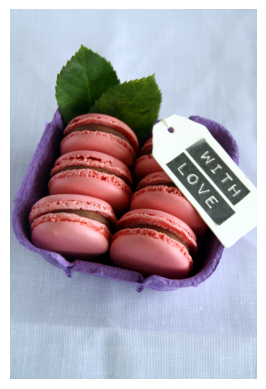

In [20]:
uploaded = files.upload()

# show image
image_path = next(iter(uploaded))
display_image(image_path)

In [37]:
# insert label images
while True:
    user_label = input("Enter the image label (number between 0 and 250): ")

    # verify the input
    if user_label.isdigit():
        user_label = int(user_label)
        # verify the value
        if 0 <= user_label <= 250:
            break
        else:
            print("Error: The label must be a number between 0 and 250. Try again")
    else:
        print("Error: Please enter a valid number. Retry")

Enter the image label (number between 0 and 250): 0


#Category Search

In [ ]:
input_image_path = list(uploaded.keys())[0]
input_image = load_and_preprocess_image(input_image_path)
input_features = model.predict(input_image).squeeze()

similarity_scores = cosine_similarity([input_features], list(load_dataset_features.values()))[0]
most_similar_indices = np.argsort(similarity_scores)[-10:][::-1]

In [ ]:
# View the 10 most similar images with their names and scores
same_label_count = 0
for index in most_similar_indices:
    file_name, features = list(load_dataset_features.items())[index]
    image_path = os.path.join(train_path, file_name)
    score = similarity_scores[index]
    score = score * 100

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = get_label(file_name, train_df)

    if label == user_label:
        same_label_count += 1

    print(f"Immagine: {file_name}, Label: {label}, Punteggio: {score:.2f}")
    display_image(image_path)

percentage_same_label = (same_label_count / 10) * 100
print(f"\nPercentuale di immagini con label identica: {percentage_same_label:.2f}%")

# Automated test category search

In [ ]:
accuracy_array = []
for i, image_path_test in enumerate(dataset_image_paths_test[:1000]):
  print(f"Image {i+1}/{len(dataset_image_paths_test)} - {image_path_test}")

  img_array = load_and_preprocess_image(image_path_test)
  most_similar_indices = get_most_similar_indices(img_array)
  file_name_test = os.path.basename(image_path_test)
  label_test = get_label(file_name_test, test_df)

  same_label_count = 0
  for index in most_similar_indices:
      file_name, features = list(load_dataset_features.items())[index]
      image_path = os.path.join(train_path, file_name)
      label = get_label(file_name, train_df)

      if int(label_test) == label:
        same_label_count += 1

  percentage_same_label = (same_label_count / 10) * 100
  accuracy_array.append(percentage_same_label)
  print(f"Correct label: {percentage_same_label}%")

print(f"\nMean of correct label on test set : {np.mean(accuracy_array):.2f}%")
print(f"\nStandard Deviation of correct label on test set : {np.std(accuracy_array):.2f}%")

Image 1/11994 - /content/test/val_set/val_010889.jpg


NameError: name 'load_dataset_features' is not defined

In [ ]:
std_deviation_value = np.std(accuracy_array)

print(f"Standard Deviation: {std_deviation_value:.2f}%")